### Importing Necessary Libraries & Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import Timestamp
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  
pd.set_option('display.float_format', lambda x: '%.3f' % x)


%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")


In [2]:
data = pd.read_csv('./data/train.csv')
data.set_index('date', inplace=True)
data.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0
2013-01-01,1,1,BABY CARE,0.000,0
2013-01-01,2,1,BEAUTY,0.000,0
2013-01-01,3,1,BEVERAGES,0.000,0
2013-01-01,4,1,BOOKS,0.000,0


## Exploratory Analysis

#### 0. Preprocessing Data

In [3]:
data.index = pd.to_datetime(data.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [4]:
#to find out unique value
print(data['family'].unique())

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


#### 1. Extracting Data to Model

Our data set has a number of stores, each with daily sales volumes for many families. 

To facilitate our first time series model, we need to use a single store and single item 

**Aggregate all of the sales for STORE 1 and `POULTRY` into a new dataframe called `sales`.**


In [5]:
sales = data.loc[(data['store_nbr'] == 1) & (data['family'] == 'POULTRY')]

In [6]:
#convert data types
sales['sales'] = sales['sales'].apply(np.int64)

In [7]:
#remove unnecessary columns as we are only interested in date and sales
sales = sales.drop(columns=['id','store_nbr','family','onpromotion'])

In [8]:
sales.head()

,sales
date,
2013-01-01,0
2013-01-02,247
2013-01-03,187
2013-01-04,258
2013-01-05,212


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `sales` with time on the $x$-axis.**

In [9]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

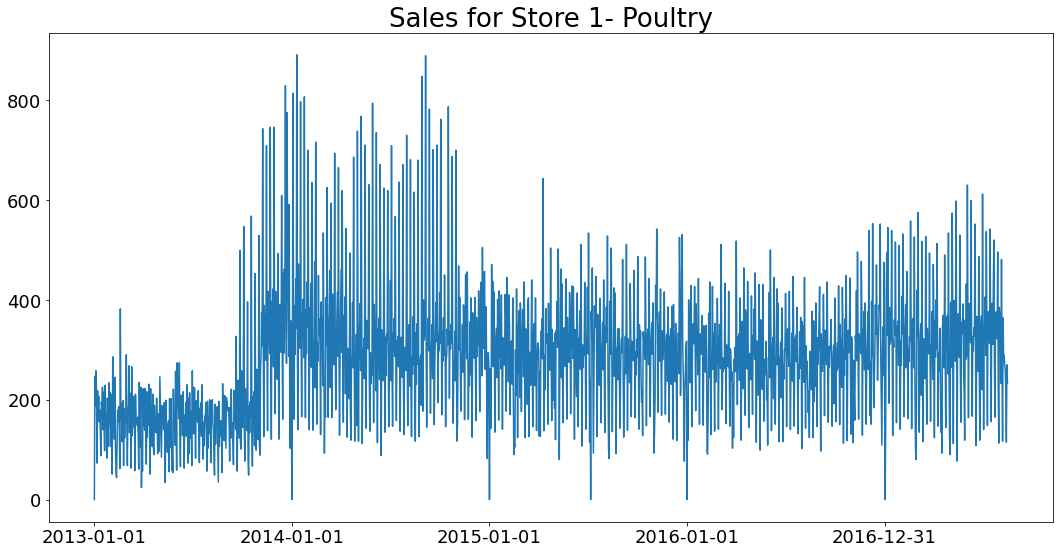

In [10]:
# Generate a time plot of our data.
plot_series(sales, ['sales'], title = "Sales for Store 1- Poultry", steps=364)

**2b. plot the monthly mean for sales

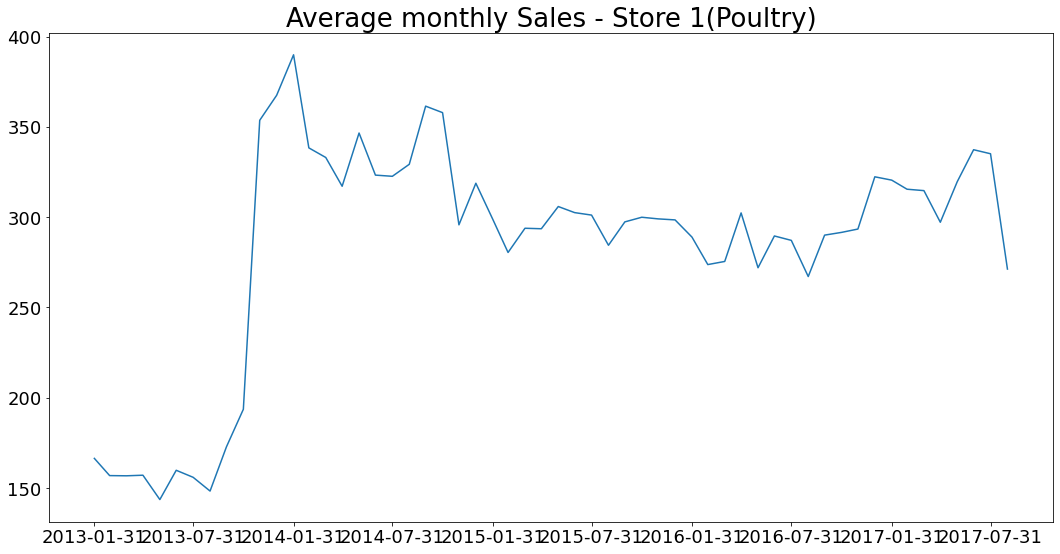

In [11]:
# Generate a time plot of our data.
plot_series(sales.resample('M').mean(), cols=['sales'], title='Average monthly Sales - Store 1(Poultry)', steps=6)

#### 3. Hyperparameter Tuning

**Parameter differencing**

In [12]:
sales.head()

,sales
date,
2013-01-01,0
2013-01-02,247
2013-01-03,187
2013-01-04,258
2013-01-05,212


In [13]:
# Look at the first 5 values of our series, differenced once.
sales.diff().head()

,sales
date,
2013-01-01,NaN
2013-01-02,247.000
2013-01-03,-60.000
2013-01-04,71.000
2013-01-05,-46.000


In [14]:
# Look at the first 5 values of our series, differenced twice.
sales.diff().diff().head()

,sales
date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,-307.000
2013-01-04,131.000
2013-01-05,-117.000


In [15]:
# Create first_diff_sales and second_diff_sales
# columns in df.
sales['first_diff_sales'] = sales['sales'].diff()
sales['second_diff_sales'] = sales['sales'].diff().diff()

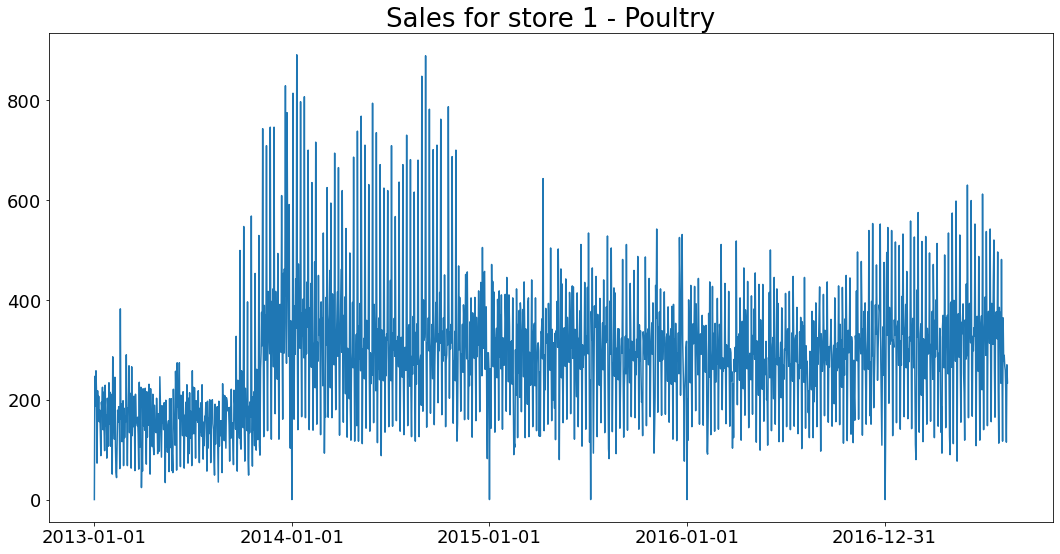

In [16]:
# sales data.
plot_series(sales,
            ['sales'],
            title = "Sales for store 1 - Poultry",
            steps = 364)

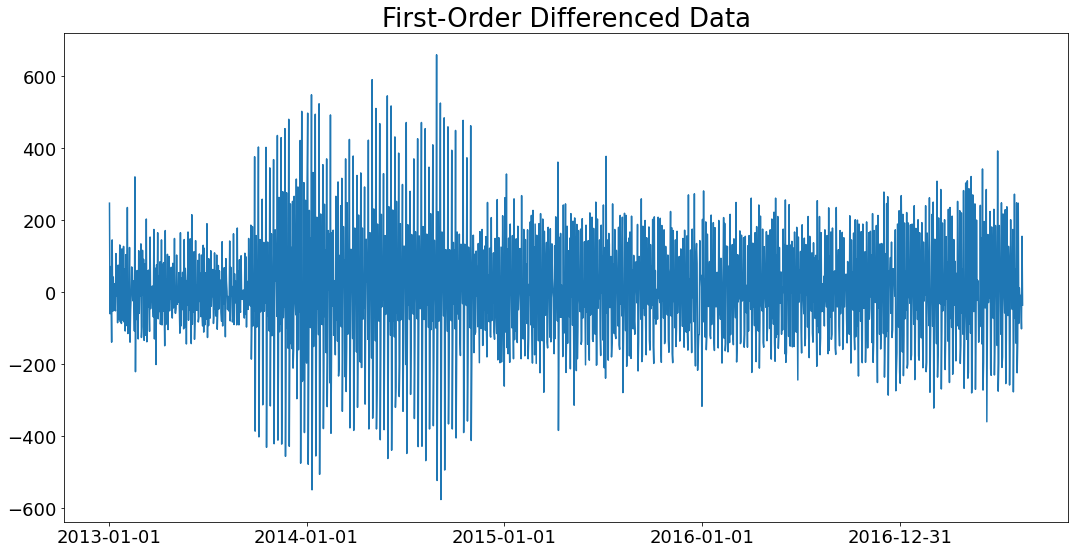

In [17]:
# Examine sales, differenced once.

plot_series(sales, ['first_diff_sales'], title = "First-Order Differenced Data", steps = 364)

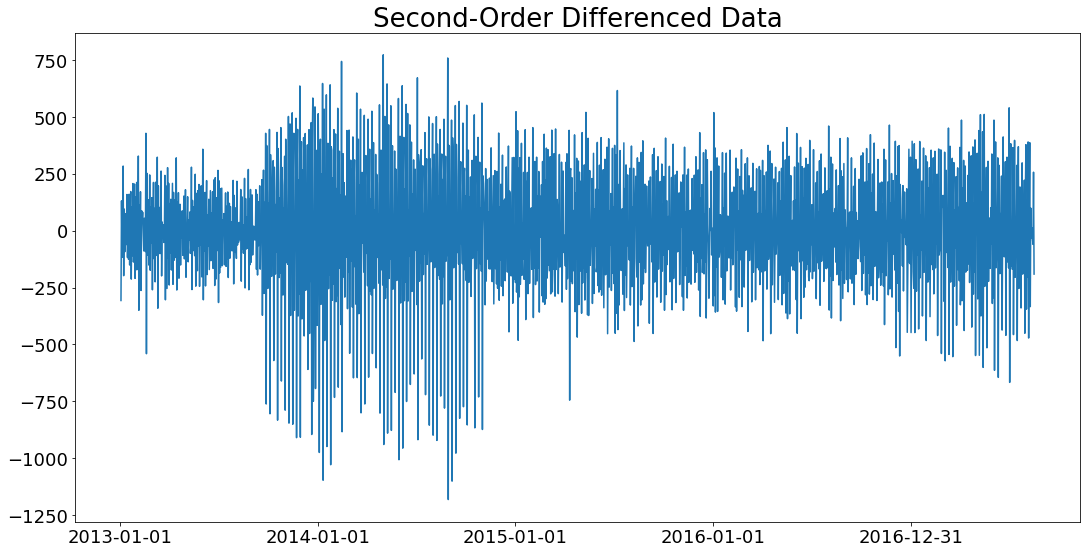

In [18]:
# Examine sales, differenced twice.

plot_series(sales, ['second_diff_sales'], title = "Second-Order Differenced Data", steps = 364)

**Augmented Dickey-Fuller Test**

In [19]:
# Run ADF test on original (non-differenced!) data.
adfuller(sales['sales'])

(-2.5422191264009464,
 0.10553688109071385,
 21,
 1662,
 {'1%': -3.4342906911169404,
  '5%': -2.8632805908715726,
  '10%': -2.5676966486957706},
 18777.881926758706)

In [20]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [21]:
# Run ADF test on original (non-differenced!) data.

interpret_dftest(adfuller(sales['sales']))

Test Statistic   -2.542
p-value           0.106
dtype: float64

In [22]:
# Run the ADF test on our once-differenced data.

interpret_dftest(adfuller(sales['sales'].diff().dropna()))

Test Statistic   -16.035
p-value            0.000
dtype: float64

In [23]:
# Run the ADF test on our twice-differenced data.

interpret_dftest(adfuller(sales['sales'].diff().diff().dropna()))

Test Statistic   -19.771
p-value            0.000
dtype: float64

In [24]:
sales.head()

,sales,first_diff_sales,second_diff_sales
date,,,
2013-01-01,0,NaN,NaN
2013-01-02,247,247.000,NaN
2013-01-03,187,-60.000,-307.000
2013-01-04,258,71.000,131.000
2013-01-05,212,-46.000,-117.000


#### 4. ARIMA model
**Train-test split**

In [25]:
# Create train-test split.
y_train, y_test = train_test_split(sales['sales'], test_size=.1, shuffle=False)

In [26]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog=y_train, order=(p, 1, q))
            
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting ARIMA(0, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54654D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   6.547D+00
  F =   6.5465382379339694     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The AIC for ARIMA(0,1,0) is: 19826.917784464058
Attempting ARIMA(0, 1, 1)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.15805D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   8.882D-08   6.158D+00
  F =   6.1580470487408210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(0,1,3) is: 18656.566463587205
Attempting ARIMA(0, 1, 4)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15865D+00    |proj g|=  8.63851D-03

At iterate    5    f=  6.15727D+00    |proj g|=  6.12843D

 This problem is unconstrained.


The AIC for ARIMA(0,1,4) is: 18656.219749343985
Attempting ARIMA(1, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42949D+00    |proj g|=  1.73195D-04

At iterate    5    f=  6.42949D+00    |proj g|=  3.61489D-05

At iterate   10    f=  6.42949D+00    |proj g|=  4.54747D-05

At iterate   15    f=  6.42949D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     20      1     0     0   8.882D-08   6.429D+00
  F =   6.4294852296331353  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.16378D+00    |proj g|=  8.33111D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   8.882D-08   6.164D+00
  F =   6.1637772314061730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(1,1,2) is: 18673.91745669789
Attempting ARIMA(1, 1, 3)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14078D+00    |proj g|=  9.32765D-04

At iterate    5    f=  6.14075D+00    |proj g|=  4.60343D-

 This problem is unconstrained.


The AIC for ARIMA(1,1,3) is: 18606.180329075967
Attempting ARIMA(1, 1, 4)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13727D+00    |proj g|=  1.14033D-03

At iterate    5    f=  6.13718D+00    |proj g|=  1.60121D-03

At iterate   10    f=  6.13716D+00    |proj g|=  7.19425D-06

At iterate   15    f=  6.13716D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     19      1     0     0   1.776D-07   6.137D+00
  F =   6.1371639264721241  

 This problem is unconstrained.


The AIC for ARIMA(1,1,4) is: 18597.33236935759
Attempting ARIMA(2, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33338D+00    |proj g|=  3.75699D-05

At iterate    5    f=  6.33338D+00    |proj g|=  8.88178D-05

At iterate   10    f=  6.33338D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   8.882D-08   6.333D+00
  F =   6.3333834047915696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH           

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14565D+00    |proj g|=  1.00417D-03

At iterate    5    f=  6.14564D+00    |proj g|=  1.14575D-05

At iterate   10    f=  6.14564D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   8.882D-08   6.146D+00
  F =   6.1456421966353112     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(2,1,2) is: 18621.004571411722
Attempting ARIMA(2, 1,

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04073D+00    |proj g|=  1.03608D-02

At iterate    5    f=  6.03988D+00    |proj g|=  2.98357D-03

At iterate   10    f=  6.03968D+00    |proj g|=  1.71179D-03

At iterate   15    f=  6.03967D+00    |proj g|=  2.07336D-03

At iterate   20    f=  6.03959D+00    |proj g|=  6.59206D-04


 This problem is unconstrained.



At iterate   25    f=  6.03959D+00    |proj g|=  3.22746D-03

At iterate   30    f=  6.03959D+00    |proj g|=  2.83817D-03

At iterate   35    f=  6.03959D+00    |proj g|=  6.54587D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     52      1     0     0   7.017D-05   6.040D+00
  F =   6.0395892396792474     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(2,1,3) is: 18301.876217748762
Attempting ARIMA(2, 1, 4)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bou

 This problem is unconstrained.



At iterate   10    f=  6.03938D+00    |proj g|=  7.32552D-03

At iterate   15    f=  6.03933D+00    |proj g|=  2.48050D-03

At iterate   20    f=  6.03932D+00    |proj g|=  2.54845D-03

At iterate   25    f=  6.03925D+00    |proj g|=  1.10091D-02

At iterate   30    f=  6.03923D+00    |proj g|=  1.24540D-03

At iterate   35    f=  6.03923D+00    |proj g|=  1.93090D-04

At iterate   40    f=  6.03923D+00    |proj g|=  4.84057D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     60      1     0     0   2.931D-05   6.039D+00
  F =   6.0392312050457138     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.16348D+00    |proj g|=  1.35181D-04

At iterate   10    f=  6.16348D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   8.882D-08   6.163D+00
  F =   6.1634753259880819     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(3,1,1) is: 18675.003287091913
Attempting ARIMA(3, 1, 2)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14389D+00    |proj g|=  1.60574D

 This problem is unconstrained.



At iterate    5    f=  6.14386D+00    |proj g|=  7.65610D-05

At iterate   10    f=  6.14385D+00    |proj g|=  2.13163D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     21      1     0     0   8.882D-08   6.144D+00
  F =   6.1438549863144374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(3,1,2) is: 18617.592898560117
Attempting ARIMA(3, 1, 3)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03931D+00    |proj g|=  9.55191D-03

At iterate    5    f=  6.03925D+00    |proj g|=  7.83773D-03

At iterate   10    f=  6.03918D+00    |proj g|=  3.73950D-03

At iterate   15    f=  6.03917D+00    |proj g|=  7.41904D-03

At iterate   20    f=  6.03916D+00    |proj g|=  3.80229D-04

At iterate   25    f=  6.03915D+00    |proj g|=  7.87672D-03

At iterate   30    f=  6.03915D+00    |proj g|=  6.45093D-03

At iterate   35    f=  6.03913D+00    |proj g|=  3.10623D-03

At iterate   40    f=  6.03912D+00    |proj g|=  1.82263D-03

At iterate   45    f=  6.03912D+00    |proj g|=  1.28377D-03

At iterate   50    f=  6.03912D+00    |proj g|=  1.88978D-03

At iterate   55    f=  6.03912D+00    |proj g|=  1.13243D-04

At iterate   60    f=  6.03912D+00    |proj g|=  6.07514D-05
  ys=-1.959E-11  -gs= 1.623

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03070D+00    |proj g|=  2.25228D-02

At iterate    5    f=  6.03048D+00    |proj g|=  1.06636D-02

At iterate   10    f=  6.03024D+00    |proj g|=  6.54534D-03

At iterate   15    f=  6.03014D+00    |proj g|=  5.30775D-03

At iterate   20    f=  6.03011D+00    |proj g|=  1.30500D-03

At iterate   25    f=  6.03010D+00    |proj g|=  7.02105D-04

At iterate   30    f=  6.03009D+00    |proj g|=  1.80060D-03

At iterate   35    f=  6.03009D+00    |proj g|=  3.03970D-03

At iterate   40    f=  6.03008D+00    |proj g|=  7.49685D-03

At iterate   45    f=  6.03008D+00    |proj g|=  8.69527D-04

At iterate   50    f=  6.03008D+00    |proj g|=  4.67448D-04

At iterate   55    f=  6.03008D+00    |proj g|=  1.86517D-04

At iterate   60    f=  6.03008D+00    |proj g|=  1.37312D-04

At iterate   65    f=  6.0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   75    f=  6.03008D+00    |proj g|=  1.23812D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     75    115      1     0     0   1.238D-04   6.030D+00
  F =   6.0300791521259409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(3,1,4) is: 18277.07967263735
Attempting ARIMA(4, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28641D+00    |proj g|=  3.89733D-04

At iterate    5    f=  6.28641D+00    |proj g|=  6.15508D-

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16139D+00    |proj g|=  2.08535D-03

At iterate    5    f=  6.16137D+00    |proj g|=  1.20526D-04

At iterate   10    f=  6.16137D+00    |proj g|=  4.44089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     17      1     0     0   1.776D-07   6.161D+00
  F =   6.1613650139639526     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(4,1,1) is: 18670.613262282848
Attempting ARIMA(4, 1,

 This problem is unconstrained.


The AIC for ARIMA(4,1,2) is: 18577.995376917657
Attempting ARIMA(4, 1, 3)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02947D+00    |proj g|=  7.63389D-03

At iterate    5    f=  6.02943D+00    |proj g|=  4.14087D-03


 This problem is unconstrained.



At iterate   10    f=  6.02940D+00    |proj g|=  4.24460D-04

At iterate   15    f=  6.02938D+00    |proj g|=  4.05276D-03

At iterate   20    f=  6.02937D+00    |proj g|=  3.19247D-03

At iterate   25    f=  6.02934D+00    |proj g|=  1.08509D-03

At iterate   30    f=  6.02933D+00    |proj g|=  1.25135D-03

At iterate   35    f=  6.02933D+00    |proj g|=  5.80958D-04

At iterate   40    f=  6.02933D+00    |proj g|=  6.93667D-05

At iterate   45    f=  6.02933D+00    |proj g|=  4.34319D-05

At iterate   50    f=  6.02933D+00    |proj g|=  4.44089D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     52     68   

 This problem is unconstrained.



At iterate    5    f=  6.02603D+00    |proj g|=  5.53468D-03

At iterate   10    f=  6.02601D+00    |proj g|=  2.70957D-03

At iterate   15    f=  6.02600D+00    |proj g|=  7.27551D-03

At iterate   20    f=  6.02598D+00    |proj g|=  3.96323D-03

At iterate   25    f=  6.02597D+00    |proj g|=  8.58842D-03

At iterate   30    f=  6.02596D+00    |proj g|=  6.31495D-04

At iterate   35    f=  6.02595D+00    |proj g|=  6.32356D-03

At iterate   40    f=  6.02595D+00    |proj g|=  1.35874D-03

At iterate   45    f=  6.02594D+00    |proj g|=  2.88560D-03

At iterate   50    f=  6.02594D+00    |proj g|=  1.34239D-03

At iterate   55    f=  6.02594D+00    |proj g|=  1.39018D-03

At iterate   60    f=  6.02594D+00    |proj g|=  1.15934D-03

At iterate   65    f=  6.02594D+00    |proj g|=  5.65237D-04

At iterate   70    f=  6.02594D+00    |proj g|=  2.55618D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

In [27]:
# Instantiate best model.
arima = ARIMA(endog=y_train, order=(4,1,4))


# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set.
preds = model.predict(start=y_test.index[0], end = y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Once-Differenced sales with ARIMA(4,1,4) Predictions', fontsize=16)
plt.show();

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02606D+00    |proj g|=  5.76259D-03


 This problem is unconstrained.



At iterate    5    f=  6.02603D+00    |proj g|=  5.53468D-03

At iterate   10    f=  6.02601D+00    |proj g|=  2.70957D-03

At iterate   15    f=  6.02600D+00    |proj g|=  7.27551D-03

At iterate   20    f=  6.02598D+00    |proj g|=  3.96323D-03

At iterate   25    f=  6.02597D+00    |proj g|=  8.58842D-03

At iterate   30    f=  6.02596D+00    |proj g|=  6.31495D-04

At iterate   35    f=  6.02595D+00    |proj g|=  6.32356D-03

At iterate   40    f=  6.02595D+00    |proj g|=  1.35874D-03

At iterate   45    f=  6.02594D+00    |proj g|=  2.88560D-03

At iterate   50    f=  6.02594D+00    |proj g|=  1.34239D-03

At iterate   55    f=  6.02594D+00    |proj g|=  1.39018D-03

At iterate   60    f=  6.02594D+00    |proj g|=  1.15934D-03

At iterate   65    f=  6.02594D+00    |proj g|=  5.65237D-04

At iterate   70    f=  6.02594D+00    |proj g|=  2.55618D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'